## Try tools

In [84]:
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from dotenv import load_dotenv
import os

load_dotenv()


def display_graph(graph):
    display(Image(graph.get_graph().draw_mermaid_png()))


CompiledStateGraph.draw = display_graph


In [91]:
from langchain_community.retrievers.pubmed import PubMedRetriever
from langchain_core.tools import tool


@tool
def pubmed_search(query: str) -> str:
    """Search PubMed for papers on a given topic"""

    def _format_response(responses):
        papers = [
            {
                "pmid": paper.metadata["uid"],
                "title": paper.metadata["Title"],
                "pub_date": paper.metadata["Published"],
                "abstract": paper.page_content,
            }
            for paper in responses
        ]

        markdown_text = "# PubMed Search Results\n\n"

        for paper in papers:
            markdown_text += f"## {paper['title']}\n"
            markdown_text += f"**PMID**: {paper['pmid']} | **Published**: {paper['pub_date']}\n\n"
            markdown_text += f"**Abstract**:\n{paper['abstract']}\n\n"

        return markdown_text

    pm_retriever = PubMedRetriever(top_k_results=20, api_key=os.getenv("NCBI_API_KEY"))
    responses = pm_retriever.invoke(query)

    return _format_response(responses)


In [92]:
from langgraph.graph import StateGraph, START, add_messages
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools([pubmed_search])

tool_node = ToolNode([pubmed_search])

In [76]:
def chatbot(state: dict) -> dict:
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph = graph_builder.compile()


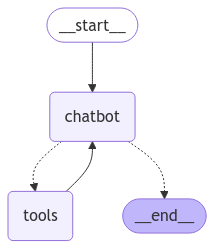

In [77]:
graph.draw()

In [94]:
response = graph.invoke({
    "messages": [
        "discuss the latest research findings on the emerging complications of Cart T-cell therapy for cancer"
    ]
})

In [95]:
print(response["messages"][-1].content)

Recent research on CAR T-cell therapy has highlighted several emerging complications and concerns associated with its use in cancer treatment. Here are some of the key findings from the latest studies:

1. **Secondary Malignancies and T-cell Neoplasias**:
   - A study published in February 2025 discusses the increasing incidence of secondary malignancies, particularly T-cell neoplasias, following CAR T-cell therapy. The FDA issued a warning regarding the potential for these complications, emphasizing the need for awareness of patient risk factors and the implications of CAR-T engineering strategies that may elevate this risk (PMID: 39894954).

2. **Thrombocytopenia**:
   - Research from January 2025 evaluated the use of thrombopoietin receptor agonists (TPO-RAs) for managing prolonged thrombocytopenia after CAR T-cell therapy. The study found no significant clinical benefit from TPO-RAs compared to supportive care, indicating that while these agents are theoretically beneficial, their 

In [82]:
from langchain_community.tools import PubmedQueryRun
from langchain_community.utilities.pubmed import PubMedAPIWrapper

In [86]:
pubmed_wrapper = PubMedAPIWrapper(api_key=os.getenv("NCBI_API_KEY"), top_k_results=10)
pqr = PubmedQueryRun(api_wrapper=pubmed_wrapper)

In [89]:
pubmed_search.invoke("Cart T-cell therapy for cancer")

'# PubMed Search Results\n\n## T-cell neoplasias and secondary malignancies after CAR-T cell therapy: current knowledge, risk factors, and implications from CAR-T engineering strategies.\n**PMID**: 39894954\n**Published**: 2025-02-02\n\n**Abstract**:\nWidespread use of CAR-T cell therapies for treatment of B cell malignancies has resulted in a frameshift in treatment strategies and improved patient outcomes since the first CAR-T product was FDA approved in 2017. Currently over 30,000 patients have been treated with approved CAR-T cell products, with many more likely to be treated in future, both as standard of care therapy as well as on clinical trials. As more patients are treated, development of rare complications has begun to emerge, and the incidence of second primary malignancies after CAR-T cell therapy is evolving from a hypothetical to a realized concern. Furthermore, in November 2023, the FDA issued a warning regarding the potential for CAR-T cell-derived T cell neoplasias to 

In [90]:
print(Out[89])

# PubMed Search Results

## T-cell neoplasias and secondary malignancies after CAR-T cell therapy: current knowledge, risk factors, and implications from CAR-T engineering strategies.
**PMID**: 39894954
**Published**: 2025-02-02

**Abstract**:
Widespread use of CAR-T cell therapies for treatment of B cell malignancies has resulted in a frameshift in treatment strategies and improved patient outcomes since the first CAR-T product was FDA approved in 2017. Currently over 30,000 patients have been treated with approved CAR-T cell products, with many more likely to be treated in future, both as standard of care therapy as well as on clinical trials. As more patients are treated, development of rare complications has begun to emerge, and the incidence of second primary malignancies after CAR-T cell therapy is evolving from a hypothetical to a realized concern. Furthermore, in November 2023, the FDA issued a warning regarding the potential for CAR-T cell-derived T cell neoplasias to arise as